In [1]:
# Please do not use GPU, it's not reliable, the results are worse. Tested using Google Colab with Premium GPU.
USE_GPU = USE_GPU if 'USE_GPU' in locals() else False # Preferred  value set by MakinaRocks Link pipeline parameters

# Misc

In [2]:
# %%sh
# pip install -U numpy pandas matplotlib joblib catboost scikit-learn

In [3]:
import warnings
warnings. filterwarnings(action= 'ignore')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import datetime as dt
import dateutil.relativedelta as rd
import itertools as it

import numpy as np
import pandas as pd

import catboost as cat

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

ModuleNotFoundError: ignored

In [6]:
# Plot charts showing model's performance
def pls_images(fpr, tpr, th, prec, recall, thpr, model, X, Y):
    plt.figure(figsize=(16,4), dpi=90)
    plt.subplot(1, 4, 1, aspect='equal')
    plt.plot(th[1:], fpr[1:], 'r', label= 'FPR')
    plt.plot(th[1:], tpr[1:], 'g', label= 'TPR(Recall)')
    plt.plot(thpr, prec[:- 1], 'b', label= 'Precision')
    plt.legend()

    plt.subplot(1, 4, 2, aspect='equal')
    plt.plot(fpr, tpr, 'r')
    plt.title('ROC curve')

    plt.subplot(1, 4, 3, aspect='equal')
    plt.plot(recall, prec, 'r')
    plt.title('P-R curve')

    ax = plt.subplot(1, 4, 4, aspect='equal')
    CalibrationDisplay.from_estimator(model, X, Y, n_bins=15, ax=ax)
    plt.xlabel('xlabel', fontsize=9)
    plt.ylabel('ylabel', fontsize=9)
    plt.show()


# Show trained model's performance on training and validation data
def model_perf(model, X, Y, prefix=''):
    p_hat = model.predict_proba(X)[:, 1]
    aucs = roc_auc_score(Y, p_hat)
    print(f'{prefix} AUROC score = {aucs:.8f}')

    fpr, tpr, th = roc_curve(Y, p_hat)
    prec, recall, thpr = precision_recall_curve(Y, p_hat)
    auprc = auc(recall, prec)
    print(f"{prefix} AUPRC score = {auprc:.8f}")

    pls_images(fpr, tpr, th, prec, recall, thpr, model, X, Y)


# Train model and show performance stats
def model_fit_perf(model, X_all, Y_all, *, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=42069)

    model.fit(X_trn, Y_trn, eval_set=(X_val, Y_val))
    print(prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    model_perf(model, X_val, Y_val, '  Validation')


# Train model on WHOLE dataset. This is for submissions.
def model_fit_final(model, X_all, Y_all, prefix=''):
    model.fit(X_all, Y_all)
    print(prefix)
    model_perf(model, X_all, Y_all, '  Whole dataset training')

# Hack for CalibratedClassifierCV

In [ ]:
# This ugly hack is code copied from CalibratedClassifierCV.fit method
# but with removed checks to fix compatibility issues with CatBoost

from inspect import signature
from joblib import Parallel
from sklearn.base import clone
from sklearn.calibration import _fit_classifier_calibrator_pair
from sklearn.model_selection import check_cv
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import indexable
from sklearn.utils.fixes import delayed


def hack_fit(self, X, y, **fit_params):
    X, y = indexable(X, y)
    estimator = self.estimator

    self.calibrated_classifiers_ = []

    label_encoder_ = LabelEncoder().fit(y)
    self.classes_ = label_encoder_.classes_
    n_classes = len(self.classes_)

    fit_parameters = signature(estimator.fit).parameters
    supports_sw = "sample_weight" in fit_parameters
    n_folds = self.cv

    cv = check_cv(self.cv, y, classifier=True)

    parallel = Parallel(n_jobs=self.n_jobs)
    self.calibrated_classifiers_ = parallel(
        delayed(_fit_classifier_calibrator_pair)(
            clone(estimator),
            X,
            y,
            train=train,
            test=test,
            method=self.method,
            classes=self.classes_,
            supports_sw=supports_sw,
            sample_weight=None,
            **fit_params,
        )
        for train, test in cv.split(X, y)
    )

    first_clf = self.calibrated_classifiers_[0].estimator
    if hasattr(first_clf, "n_features_in_"):
        self.n_features_in_ = first_clf.n_features_in_
    if hasattr(first_clf, "feature_names_in_"):
        self.feature_names_in_ = first_clf.feature_names_in_
    return self


CalibratedClassifierCV.fit = hack_fit

# Common

In [ ]:
# Non-timeseries columns
non_date_cols = ['gender', 'age_code', 'region_code']

# Prefixes for timeseries columns
ts_prefix = ['c', 's', 't']

# First day in the dataset
first_day = dt.datetime(2022, 1, 1)

# Load

In [ ]:
# Let's use float32 to save some RAM
dtypeX = {
    'gender': np.uint8,
    'age_code': np.uint8,
    'region_code': np.uint8
}

for i in range(238):
    d = (first_day + rd.relativedelta(days=i)).date()
    for prefix in ts_prefix:
        dtypeX[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}'] = np.float32

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del i

In [ ]:
X_model = pd.read_csv('data/X_model.csv', dtype=dtypeX)
X_model.fillna(0, inplace=True)
#X_model.info(verbose=True, null_counts=True)
X_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 717 entries, gender to t20220826
dtypes: float32(714), uint8(3)
memory usage: 2.1 GB


In [ ]:
E = pd.read_csv('data/X_exam.csv', dtype=dtypeX)
E.fillna(0, inplace=True)
#X_model.info(verbose=True, null_counts=True)
E.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 717 entries, gender to t20220826
dtypes: float32(714), uint8(3)
memory usage: 545.3 MB


In [ ]:
Y_model = pd.read_csv('data/Y_model.csv', dtype={'business': np.int8})['business']
#Y_model.info(verbose=True, null_counts=True)
Y_model.info()

<class 'pandas.core.series.Series'>
RangeIndex: 800000 entries, 0 to 799999
Series name: business
Non-Null Count   Dtype
--------------   -----
800000 non-null  int8 
dtypes: int8(1)
memory usage: 781.4 KB


# Prepare

In [ ]:
# The *_aggr dataframes are just temporary dataframes used for intermediate resutls
X_aggr = pd.DataFrame()
E_aggr = pd.DataFrame()

In [ ]:
# Create sum, mean and std of every TS
for i, prefix in enumerate(ts_prefix):
    X_aggr[f'{prefix}_sum'] = X_model.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].sum(axis=1)
    X_aggr[f'{prefix}_mean'] = X_model.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].mean(axis=1)
    X_aggr[f'{prefix}_std'] = X_model.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].std(axis=1)

    E_aggr[f'{prefix}_sum'] = E.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].sum(axis=1)
    E_aggr[f'{prefix}_mean'] = E.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].mean(axis=1)
    E_aggr[f'{prefix}_std'] = E.iloc[:, (238*i) + 3:(238*(i+1)) + 3:].std(axis=1)

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del i
del prefix

In [ ]:
# Multiply and divide every TS category with each other
for prefix in ts_prefix:
    for prefix2 in [p for p in ts_prefix if p != prefix]:
        X_aggr[f'{prefix}_mul_{prefix2}'] = X_aggr[f'{prefix}_sum'] * X_aggr[f'{prefix2}_sum']
        X_aggr[f'{prefix}_div_{prefix2}'] = X_aggr[f'{prefix}_sum'] / X_aggr[f'{prefix2}_sum']
        X_aggr[X_aggr == np.inf] = np.finfo(np.float32).max

        E_aggr[f'{prefix}_mul_{prefix2}'] = E_aggr[f'{prefix}_sum'] * E_aggr[f'{prefix2}_sum']
        E_aggr[f'{prefix}_div_{prefix2}'] = E_aggr[f'{prefix}_sum'] / E_aggr[f'{prefix2}_sum']
        E_aggr[E_aggr == np.inf] = np.finfo(np.float32).max

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del prefix2
del prefix

In [ ]:
# Aggregate TS values by weekdays
for prefix in ts_prefix:
    for weekday in range(7):
        col_name = f'{prefix}_W{(first_day + dt.timedelta(days=weekday)).weekday()}'

        X_aggr[col_name] = X_model.drop(columns=non_date_cols).iloc[:, weekday::7].sum(axis=1)

        E_aggr[col_name] = E.drop(columns=non_date_cols).iloc[:, weekday::7].sum(axis=1)

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del weekday
del prefix

In [ ]:
# Aggregate TS values by first and last business day of month and by holidays
holidays = [dt.date(2022, 1, 1), dt.date(2022, 1, 31), dt.date(2022, 2, 1), dt.date(2022, 2, 2), dt.date(2022, 3, 1), dt.date(2022, 3, 9), dt.date(2022, 5, 5), dt.date(2022, 5, 8), dt.date(2022, 6, 1), dt.date(2022, 6, 6), dt.date(2022, 8, 15)]

dates_all = [(first_day + rd.relativedelta(days=i)).date() for i in range(238)]
dates_all = [d for d in dates_all if d.weekday() <= 4 and d not in set(holidays)]
dates_all = [list(g[1]) for g in it.groupby(dates_all, lambda d: d.month)]
fbd = [m[0] for m in dates_all]
lbd = [m[-1] for m in dates_all][:-1]

for prefix in ts_prefix:
    biz_col = [f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in set(fbd + lbd + holidays)]
    X_aggr[biz_col] = X_model[biz_col]
    X_aggr[f'{prefix}_fbd_sum'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in fbd]].sum(axis=1)
    X_aggr[f'{prefix}_lbd_sum'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in lbd]].sum(axis=1)
    X_aggr[f'{prefix}_hol_sum'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in holidays]].sum(axis=1)

    E_aggr[biz_col] = E[biz_col]
    E_aggr[f'{prefix}_fbd_sum'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in fbd]].sum(axis=1)
    E_aggr[f'{prefix}_lbd_sum'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in lbd]].sum(axis=1)
    E_aggr[f'{prefix}_hol_sum'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in holidays]].sum(axis=1)

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del prefix

In [ ]:
# Get first and last N days in the month -> (first N days of a month) + (days in between) + (last N days of a month)
n_days = 8
fdm = [[(first_day + rd.relativedelta(days=d, months=m)).date() for d in range(n_days)] for m in range(8)]
ldm = [[(first_day + rd.relativedelta(days=-d, months=(1 + m), seconds=-1)).date() for d in range(n_days)] for m in range(7)]

# And get also the days between these N days
mdm = [
    [
        (first_day + rd.relativedelta(days=n_days + d, months=m)).date()
        for d
        in range(
            (
                (first_day + rd.relativedelta(days=-n_days, months=(1 + m), seconds=-1))
                -
                (first_day + rd.relativedelta(days=n_days, months=m))
            ).days
        )
    ]
    for m
    in range(7)
]

In [ ]:
# Group by these first and last N days and the days between them
for prefix in ts_prefix:
    for i, day_range in enumerate(fdm):
        X_aggr[f'{prefix}_fd_{i}'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        X_aggr[f'{prefix}_fd_{i}_mean'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)

        E_aggr[f'{prefix}_fd_{i}'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        E_aggr[f'{prefix}_fd_{i}_mean'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)
    for i, day_range in enumerate(ldm):
        X_aggr[f'{prefix}_ld_{i}'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        X_aggr[f'{prefix}_ld_{i}_mean'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)

        E_aggr[f'{prefix}_ld_{i}'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        E_aggr[f'{prefix}_ld_{i}_mean'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)
    for i, day_range in enumerate(mdm):
        X_aggr[f'{prefix}_md_{i}'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        X_aggr[f'{prefix}_md_{i}_mean'] = X_model[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)

        E_aggr[f'{prefix}_md_{i}'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].sum(axis=1)
        E_aggr[f'{prefix}_md_{i}_mean'] = E[[f'{prefix}{d.year}{d.month:0>2}{d.day:0>2}' for d in day_range]].mean(axis=1)

# We need to free temporary variables to make Link stop crying when they get overwritten in the future
del i
del day_range
del prefix

In [ ]:
# Get frequency of 5 days logins
X_aggr['freq5'] = X_model.iloc[:, 0 + 3:238 + 3:].rolling(window=5, min_periods=1, axis=1).sum().gt(0).astype(np.uint8).sum(axis=1)

E_aggr['freq5'] = E.iloc[:, 0 + 3:238 + 3:].rolling(window=5, min_periods=1, axis=1).sum().gt(0).astype(np.uint8).sum(axis=1)

In [ ]:
# Get number of N days long streaks of logins
frqX = (X_model.iloc[:, 0 + 3:238 + 3:] != 0).cumsum(axis=1) - (
    (X_model.iloc[:, 0 + 3:238 + 3:] != 0).cumsum(axis=1)
    .where(X_model.iloc[:, 0 + 3:238 + 3:] == 0)
    .ffill(axis=1)
    .fillna(0)
)

X_aggr['f3'] = (frqX >= 3).sum(axis=1)
X_aggr['f5'] = (frqX >= 5).sum(axis=1)
X_aggr['f7'] = (frqX >= 7).sum(axis=1)

frqE = (E.iloc[:, 0 + 3:238 + 3:] != 0).cumsum(axis=1) - (
    (E.iloc[:, 0 + 3:238 + 3:] != 0).cumsum(axis=1)
    .where(E.iloc[:, 0 + 3:238 + 3:] == 0)
    .ffill(axis=1)
    .fillna(0)
)

E_aggr['f3'] = (frqE >= 3).sum(axis=1)
E_aggr['f5'] = (frqE >= 5).sum(axis=1)
E_aggr['f7'] = (frqE >= 7).sum(axis=1)

In [ ]:
# Concatenate aggregated dataset with the whole dataset
X_work = pd.concat([X_model, X_aggr], axis=1)

E_work = pd.concat([E, E_aggr], axis=1)

In [ ]:
# Free some memory, the datasets won't be used after preprocessing
del X_model
del E

del X_aggr
del E_aggr

del frqX
del frqE

In [ ]:
# And drop duplicate columns
X_work = X_work.loc[:,~X_work.columns.duplicated()]

E_work = E_work.loc[:,~E_work.columns.duplicated()]

In [ ]:
# # Save preprocessed data files to work with in Google Collab (where preprocessing fails due to low RAM)
# # in HDF format to make the process faster and to keep the data types
X_work.to_hdf(f'data/pre-X_work-{dt.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.%f")}.h5', key='stage', mode='w')

E_work.to_hdf(f'data/pre-E_work-{dt.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.%f")}.h5', key='stage', mode='w')

# Train

In [ ]:
# Overfits, don't use. Found using GPU.
# best_optuna_catboost_params = {'objective': 'Logloss', 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 1.0}

# Old but better hyperparams
best_optuna_catboost_params = {'objective': 'Logloss', 'colsample_bylevel': 1, 'depth': 5, 'bootstrap_type': 'MVS'}

Learning rate set to 0.156328
0:	learn: 0.4482457	test: 0.4491849	best: 0.4491849 (0)	total: 364ms	remaining: 6m 3s
1:	learn: 0.3279188	test: 0.3289632	best: 0.3289632 (1)	total: 734ms	remaining: 6m 6s
2:	learn: 0.2591278	test: 0.2600168	best: 0.2600168 (2)	total: 1.05s	remaining: 5m 48s
3:	learn: 0.2284707	test: 0.2292660	best: 0.2292660 (3)	total: 1.38s	remaining: 5m 44s
4:	learn: 0.2119963	test: 0.2127041	best: 0.2127041 (4)	total: 1.7s	remaining: 5m 37s
5:	learn: 0.1975467	test: 0.1981428	best: 0.1981428 (5)	total: 2.05s	remaining: 5m 40s
6:	learn: 0.1912637	test: 0.1917981	best: 0.1917981 (6)	total: 2.36s	remaining: 5m 35s
7:	learn: 0.1867533	test: 0.1872836	best: 0.1872836 (7)	total: 2.71s	remaining: 5m 35s
8:	learn: 0.1838257	test: 0.1843102	best: 0.1843102 (8)	total: 3.05s	remaining: 5m 35s
9:	learn: 0.1805078	test: 0.1809411	best: 0.1809411 (9)	total: 3.37s	remaining: 5m 33s
10:	learn: 0.1787735	test: 0.1792017	best: 0.1792017 (10)	total: 3.7s	remaining: 5m 32s
11:	learn: 0.17

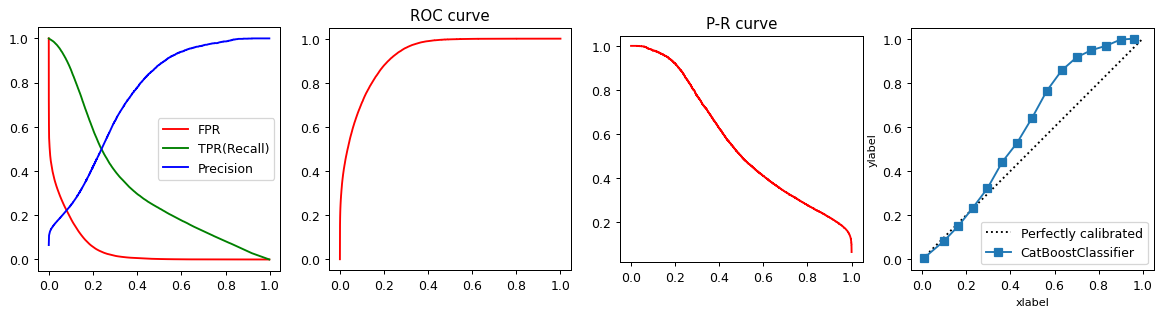

  Validation AUROC score = 0.90297664
  Validation AUPRC score = 0.44140096


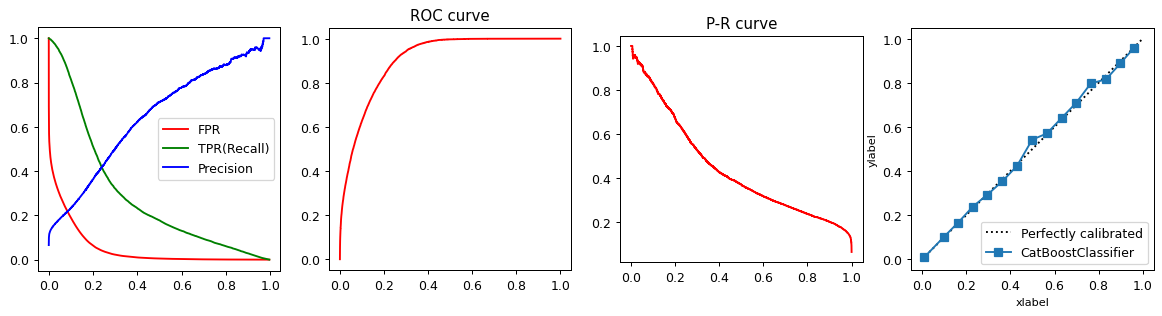

In [ ]:
# Uncomment and run only when required, it takes time

# Uncalibrated model
cc_uncal = cat.CatBoostClassifier(
    **best_optuna_catboost_params,
    cat_features=['region_code'],
    random_state=42069,
    task_type='GPU' if USE_GPU else 'CPU'
)
model_fit_perf(cc_uncal, X_work, Y_model, prefix='CatBoost - Optuna params')

In [ ]:
# This one is the one we want to run, but it takes almost 25 minutes

# # Isotonic calibration
# cc2 = CalibratedClassifierCV(
#     cat.CatBoostClassifier(
#         **best_optuna_catboost_params,
#         cat_features=['region_code'],
#         random_state=42069,
#         task_type='GPU' if USE_GPU else 'CPU'
#     ),
#     method='isotonic'
# )
# model_fit_perf(cc2, X_work, Y_model, prefix='CatBoost - Optuna params + calibrated2')

# Final train

Learning rate set to 0.16262
0:	learn: 0.4420309	total: 309ms	remaining: 5m 8s
1:	learn: 0.3151937	total: 685ms	remaining: 5m 41s
2:	learn: 0.2541715	total: 1.03s	remaining: 5m 42s
3:	learn: 0.2254433	total: 1.32s	remaining: 5m 30s
4:	learn: 0.2071696	total: 1.69s	remaining: 5m 35s
5:	learn: 0.1977901	total: 2s	remaining: 5m 31s
6:	learn: 0.1903612	total: 2.3s	remaining: 5m 26s
7:	learn: 0.1852180	total: 2.64s	remaining: 5m 27s
8:	learn: 0.1809514	total: 3s	remaining: 5m 30s
9:	learn: 0.1793547	total: 3.34s	remaining: 5m 30s
10:	learn: 0.1772855	total: 3.65s	remaining: 5m 27s
11:	learn: 0.1764051	total: 4.01s	remaining: 5m 29s
12:	learn: 0.1755618	total: 4.31s	remaining: 5m 27s
13:	learn: 0.1750180	total: 4.59s	remaining: 5m 23s
14:	learn: 0.1744369	total: 4.9s	remaining: 5m 21s
15:	learn: 0.1730577	total: 5.29s	remaining: 5m 25s
16:	learn: 0.1726030	total: 5.55s	remaining: 5m 21s
17:	learn: 0.1722574	total: 5.89s	remaining: 5m 21s
18:	learn: 0.1712560	total: 6.24s	remaining: 5m 22s
19

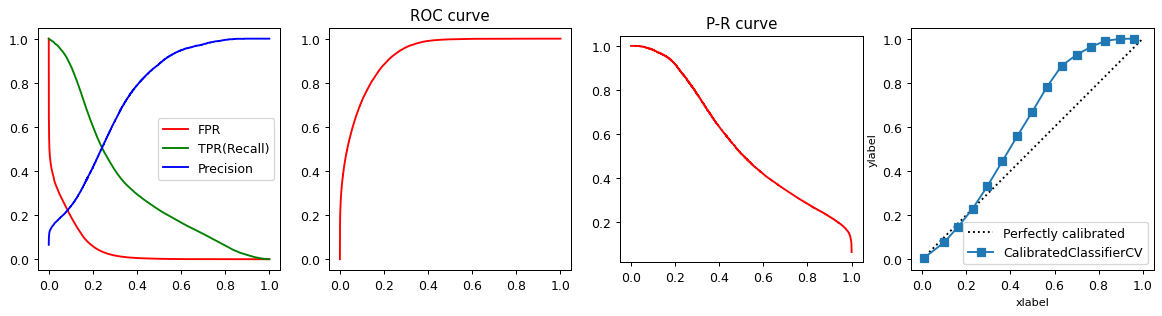

In [ ]:
# Calibrated model with optimized hyperparameters
cc_fin = CalibratedClassifierCV(
    cat.CatBoostClassifier(
        **best_optuna_catboost_params,
        cat_features=['region_code'],
        random_state=42069,
        task_type='GPU' if USE_GPU else 'CPU'
    ),
    method='isotonic'
)
model_fit_final(cc_fin, X_work, Y_model, prefix='CatBoost - Optuna params + Calibration - FINAL')

# Submission

In [ ]:
S = pd.DataFrame(columns=['business_prob', 'popup', 'survey'])

In [ ]:
S['business_prob'] = cc_fin.predict_proba(E_work)[:, 1]

In [ ]:
S['popup'] = np.where(S['business_prob'] > 400/4600, 1, 0)

In [ ]:
t3_ordered = sorted(S['business_prob'], reverse=True)
t3_threshold = t3_ordered[50000]
S['survey'] = np.where(S['business_prob'] > t3_threshold, 1, 0)

t3_check = (S['survey'] == 1).sum()
print(f'There is {t3_check} survey, which is {"!!!MORE!!!" if t3_check > 50000 else "less"} than the limit')

There is 50000 survey, which is less than the limit


In [ ]:
S.to_csv(f'pls_submit_{dt.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.%f")}.csv', index=False, float_format="%.10f")